# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import mean_absolute_error,mean_squared_error,  r2_score
from pycaret.regression import *
from pycaret.utils import check_metric

# Load Data

In [73]:
panCancer_train_df = pd.read_csv('../../D2GNets/data/panCancer_train_CGC_657_DR_Drug_features_new_df.csv')
GBM_train_df = pd.read_csv('../../D2GNets/data/GBM_train_CGC_657_DR_Drug_features_new_df.csv')

In [92]:
panCancer_df = pd.concat([panCancer_train_df,GBM_train_df],axis=0)

In [108]:
repurposing_df = pd.read_csv('../../D2GNets/data/Repurposing.csv')

# Feature Engineeing (Step-2)

In [94]:
# Removing Features based on Feature Score less than 70
featureScore = pd.read_csv('../../D2GNets/supplementary_material/featureScore.csv')
featureScore = featureScore[featureScore['Score']>=70]
features = set(featureScore['Name'].to_list())

In [95]:
# Getting the column names
disease_cols = (pd.read_csv('../../D2GNets/data/diseaseNames.csv')).columns.tolist()
GE_cols =  (pd.read_csv('../../D2GNets/data/657_Gene_name.csv')).columns.tolist()
drug_cols =  (pd.read_csv('../../D2GNets/data/moleculeNames_v1.csv')).columns.tolist()

Drug_Xcols = list(features.intersection(set(drug_cols)))
GE_Xcols = GE_cols#list(features.intersection(set(panCancer_train_df.columns[55+2986:].to_list())))

In [96]:
print(f"No. of Diseases: {len(disease_cols)}")
print(f"No. of Drugs Features: {len(Drug_Xcols)}")
print(f"No. of GENEs: {len(GE_Xcols)}")

No. of Diseases: 31
No. of Drugs Features: 1968
No. of GENEs: 657


# Data Preparation for ML operation

### Data for Drug Repurposing Experiments

In [97]:
GBM_test_Carmustine = panCancer_df[(panCancer_df['DRUG_NAME']=='Carmustine')
                                   &(panCancer_df['TCGA_DESC']=='GBM')].copy(deep=True)
GBM_test_Temozolomide = panCancer_df[(panCancer_df['DRUG_NAME']=='Temozolomide')
                                     &(panCancer_df['TCGA_DESC']=='GBM')].copy(deep=True)

In [98]:
GBM_test_Temozolomide.shape

(24, 3681)

### Data for Drug Screening Experiments

In [99]:
indx_4_drugs = (GBM_test_Carmustine.index.to_list()+
 GBM_test_Temozolomide.index.to_list())
panCancer_df.drop(index=indx_4_drugs,inplace=True)

In [100]:
#panCancer_df = pd.concat([panCancer_train_df,GBM_train_df],axis=0)
panCancer_df = panCancer_df[disease_cols+Drug_Xcols+GE_Xcols+['TCGA_DESC','SAMPLE_ID','DRUG_NAME','LN_IC50']]
panCancer_df.dropna(inplace=True)

In [101]:
train = panCancer_df.sample(frac=0.8).copy(deep=True)# Training data for Drug Screening
test = panCancer_df.drop(index=train.index).copy(deep=True) # Test Data for Drug Screening

In [102]:
test_gbm = test[test['TCGA_DESC']=='GBM'].copy(deep=True)
train1 = test_gbm.drop(index=test_gbm.index).copy(deep=True)
train = pd.concat([train,train1],axis=0,ignore_index=True)

In [103]:
print(f"Train data size: {train.shape[0]}")
print(f"Test data size: {test.shape[0]}")

Train data size: 96180
Test data size: 22845


In [104]:
train.columns[:34]

Index(['ACC', 'ALL', 'BLCA', 'BRCA', 'CESC', 'CLL', 'COREAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KIRC', 'LAML', 'LCML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
       'MB', 'MESO', 'MM', 'NB', 'OV', 'PAAD', 'PRAD', 'SCLC', 'SKCM', 'STAD',
       'THCA', 'UCEC', 'UNCLASSIFIED',
       'mol1 mol2 mol1 mol1 mol2 mol2 mol1 mol2', 'mol1 mol6 mol1 mol1 mol6',
       'mol2 mol2 mol1 mol2 mol6 mol1 mol1 mol1'],
      dtype='object')

In [105]:
cols = disease_cols+Drug_Xcols+GE_Xcols+['TCGA_DESC','SAMPLE_ID','DRUG_NAME','LN_IC50']

In [128]:
x1=pd.DataFrame({'Feature': disease_cols+Drug_Xcols+GE_Xcols}).to_csv('../../D2GNets/results/feature_exp11.csv')

In [109]:
repurposing_df = repurposing_df[disease_cols+Drug_Xcols+GE_Xcols+['TCGA_DESC','SAMPLE_ID','DRUG_NAME']]

# Drug Screening Model development

In [107]:
exp = setup(data=train[cols], target='LN_IC50',ignore_features=['TCGA_DESC','SAMPLE_ID','DRUG_NAME'],numeric_features=disease_cols+Drug_Xcols+GE_Xcols
           ,transformation = False, normalize=False,use_gpu=True)

,Description,Value
0,session_id,7677
1,Target,LN_IC50
2,Original Data,"(96180, 2660)"
3,Missing Values,False
4,Numeric Features,2656
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(67325, 1303)"


In [52]:
mdl1= compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7889,1.0722,1.0348,0.8531,0.2758,0.6539,0.8820
ridge,Ridge Regression,0.7871,1.0805,1.0380,0.8520,0.2787,0.6850,0.1100
br,Bayesian Ridge,0.7894,1.0849,1.0401,0.8514,0.2789,0.6806,1.0480
lr,Linear Regression,0.7938,1.1024,1.0485,0.8490,0.2817,0.6730,0.4450
huber,Huber Regressor,0.7852,1.1061,1.0502,0.8486,0.2833,0.6974,3.1860
omp,Orthogonal Matching Pursuit,0.7994,1.1164,1.0552,0.8472,0.2807,0.6896,0.0750
rf,Random Forest Regressor,0.8116,1.1410,1.0664,0.8438,0.2861,0.6763,7.6300
et,Extra Trees Regressor,0.8431,1.2440,1.1142,0.8296,0.2949,0.6881,6.0140
gbr,Gradient Boosting Regressor,0.9077,1.3233,1.1485,0.8193,0.3009,0.8448,11.9810
par,Passive Aggressive Regressor,1.0443,1.8357,1.3510,0.7496,0.3453,0.9471,0.2380


In [53]:
mdl1_1 = pull()
mdl1_1.to_csv('../../D2GNets/results/modelSelection_GBM_exp1.csv')

In [110]:
mdl = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8951,1.4247,1.1936,0.8234,0.3245,1.9971
1,0.8765,1.3795,1.1745,0.8283,0.3232,1.7507
2,0.8796,1.3801,1.1748,0.8324,0.3199,1.2391
3,0.8939,1.3999,1.1832,0.8269,0.3271,6.7267
4,0.8903,1.4048,1.1852,0.8259,0.3206,1.6715
5,0.8846,1.3745,1.1724,0.8279,0.3205,5.1848
6,0.8783,1.3608,1.1665,0.8316,0.3272,1.1288
7,0.8793,1.3657,1.1687,0.8250,0.3209,0.9249
8,0.8736,1.3482,1.1611,0.8222,0.3131,0.8892
9,0.9103,1.4924,1.2217,0.8172,0.3336,1.5355


In [111]:
x=pd.DataFrame({'Feature': get_config('X_train').columns}).to_csv('../../D2GNets/results/feature_exp1.csv')

1303

In [112]:
lgbm_res= pull()

In [113]:
lgbm_res.to_csv('../../D2GNets/results/LGBM10fold_GBM_exp1.csv')

In [114]:
final_mdl = finalize_model(mdl)
save_model(final_mdl,'../../D2GNets/models/LGBM/Exp1_hackathon')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['TCGA_DESC', 'SAMPLE_ID',
                                                        'DRUG_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['ACC', 'ALL', 'BLCA',
                                                           'BRCA', 'CESC', 'CLL',
                                                           'COREAD', 'DLBC',
                                                           'ESCA', 'GBM', 'HNSC',
                                                           'KIRC', 'LAML',
                                                           'LCML', 'LGG', 'LIHC',
                                                           'LUAD', 'LUSC', 'MB',
                                   

# Drug Screening experiment with Test data

In [115]:
# Prediction
unseen_predict =predict_model(mdl, data=test_gbm[cols])

In [116]:
#saving the resutlt
unseen_predict.to_csv('../../D2GNets/results/unseen_predict_exp1.csv',index=False)

# Drug Repurposing Experiment 

In [117]:
# Prediction 
GBM_Carmustine_pred = predict_model(final_mdl, data=GBM_test_Carmustine[cols])
GBM_Temozolomide_pred = predict_model(final_mdl, data=GBM_test_Temozolomide[cols])

In [118]:
# Saving the Results of drug Repurposing
GBM_Carmustine_pred.to_csv('../../D2GNets/results/GBM_Carmustine_pred_exp3.csv',index=False)
GBM_Temozolomide_pred.to_csv('../../D2GNets/results/GBM_Temozolomide_pred_exp3.csv',index=False)

In [119]:
def metrics_func(true_label,prediction):
    lst = []
    lst.append(check_metric(true_label, prediction,'MAE',))
    lst.append(check_metric(true_label, prediction,'MSE'))
    lst.append(check_metric(true_label, prediction,'RMSE'))
    lst.append(check_metric(true_label, prediction,'R2'))
    lst.append(check_metric(true_label,prediction,'RMSLE'))
    lst.append(check_metric(true_label, prediction,'MAPE'))
    return lst

In [120]:
metrics_func(unseen_predict['LN_IC50'],unseen_predict['Label'])

[0.7765, 1.0434, 1.0215, 0.8509, 0.2817, 1.3157]

In [121]:
unseen_predict1 =predict_model(final_mdl, data=repurposing_df)

In [122]:
unseen_predict1.to_csv('../../D2GNets/results/unseen_predict_repurpose_exp4.csv',index=False)

In [123]:
unseen_predict1['DRUG_CODE'] = unseen_predict1['DRUG_NAME'].astype('category').cat.codes

In [124]:
samples = unseen_predict1['SAMPLE_ID'].unique()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

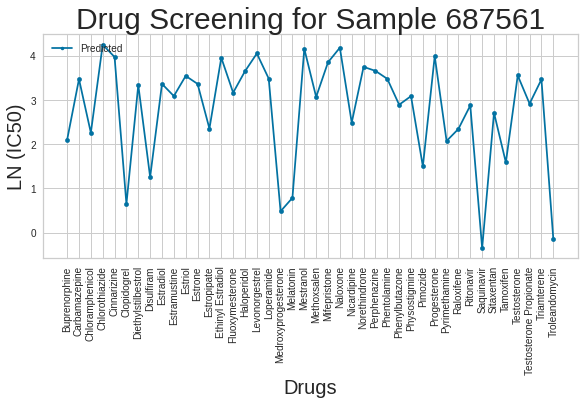

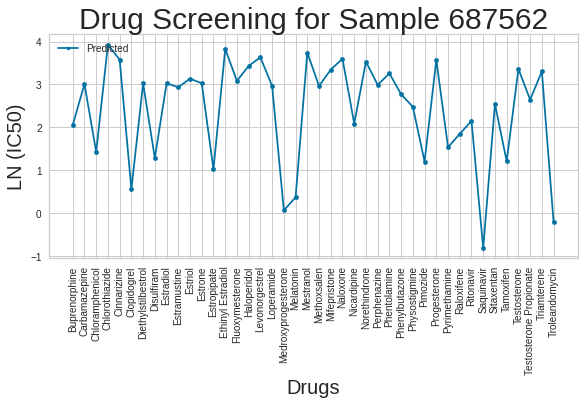

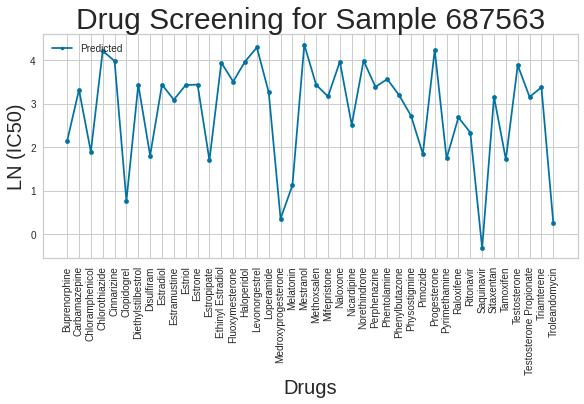

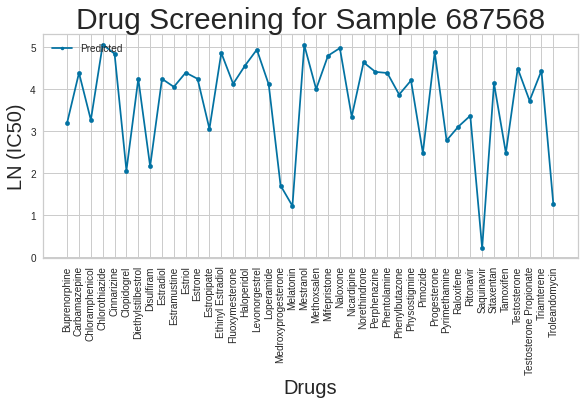

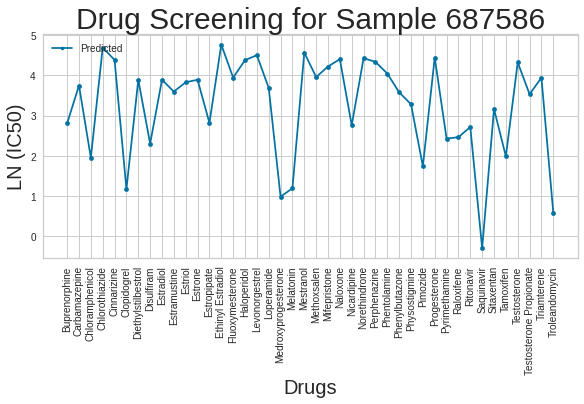

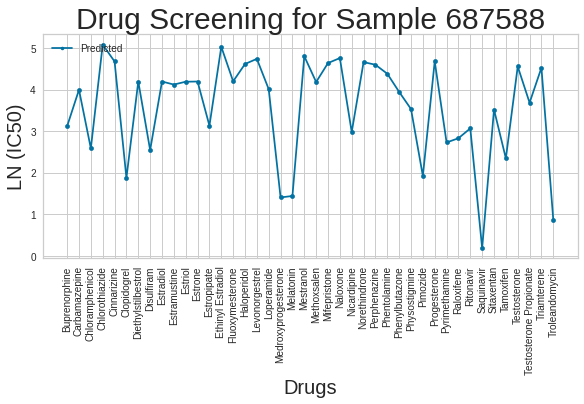

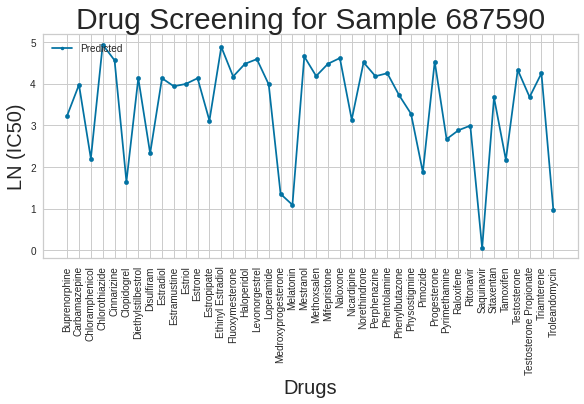

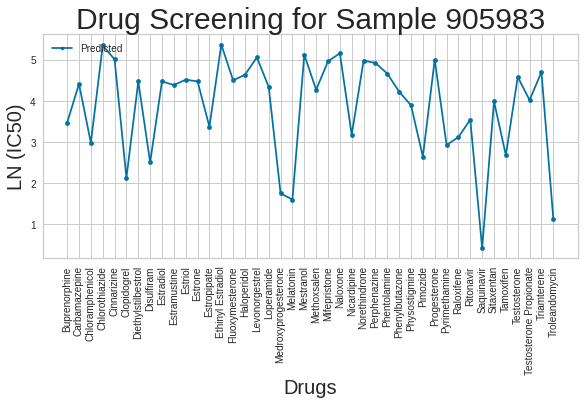

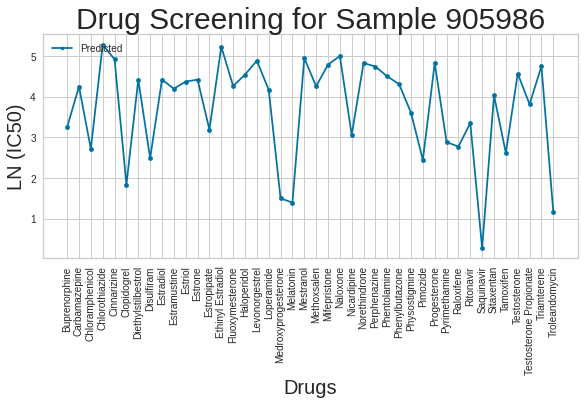

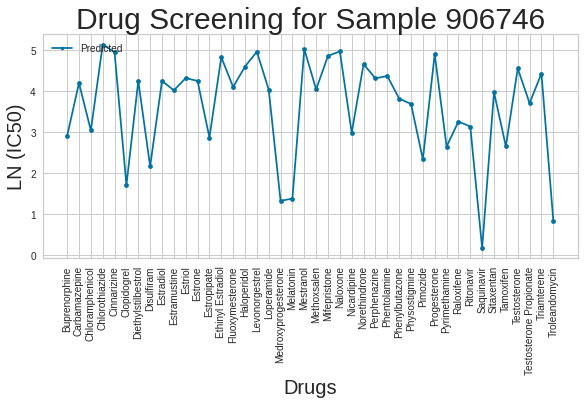

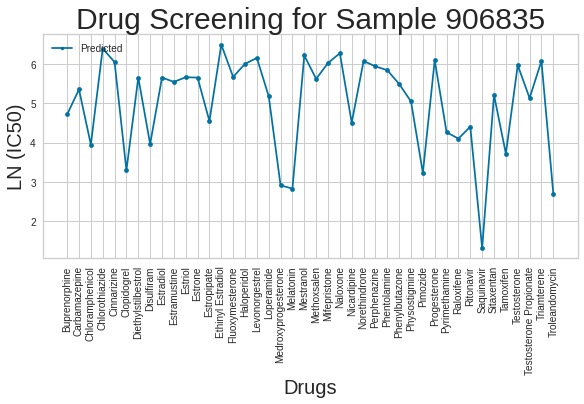

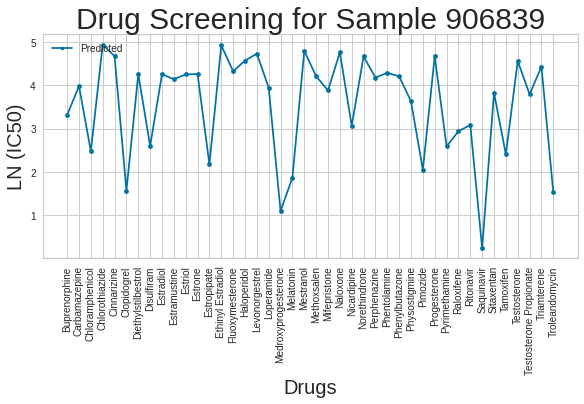

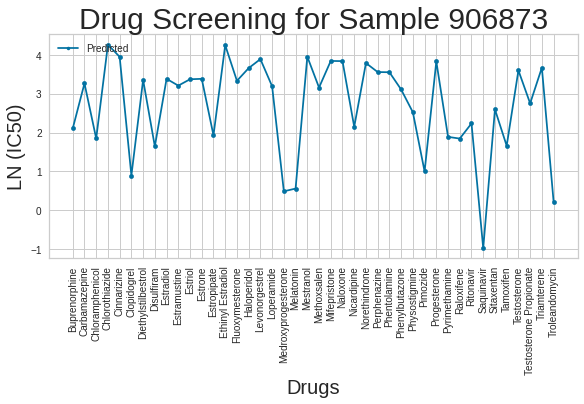

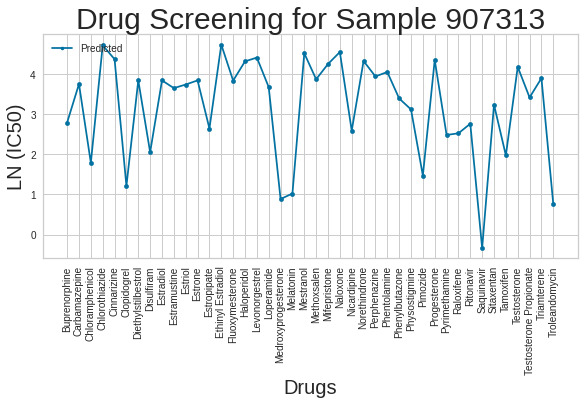

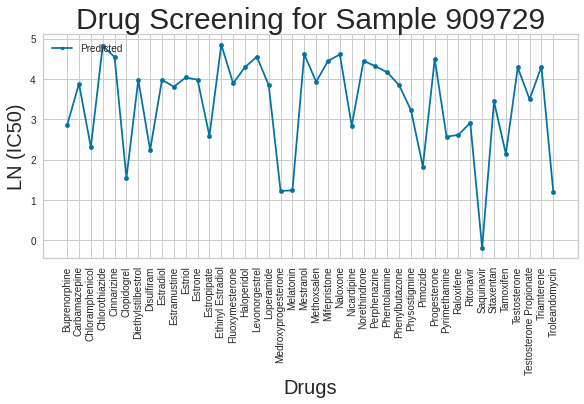

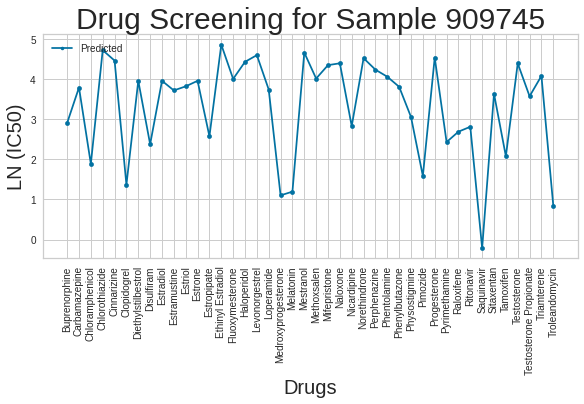

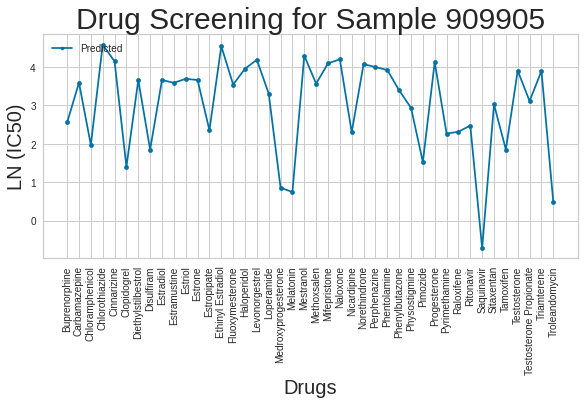

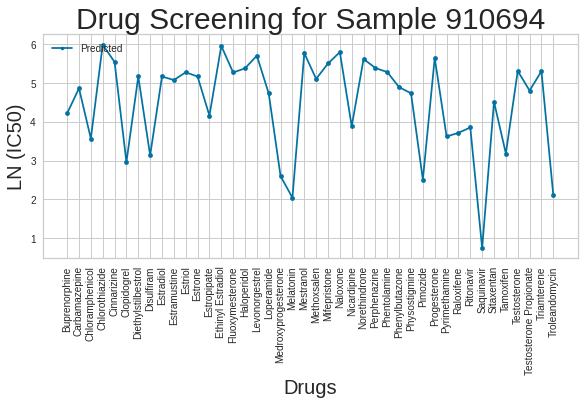

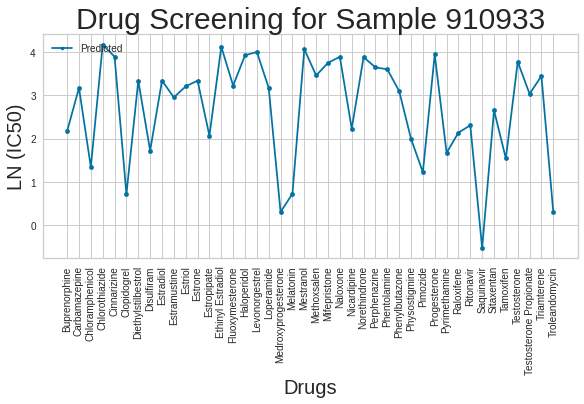

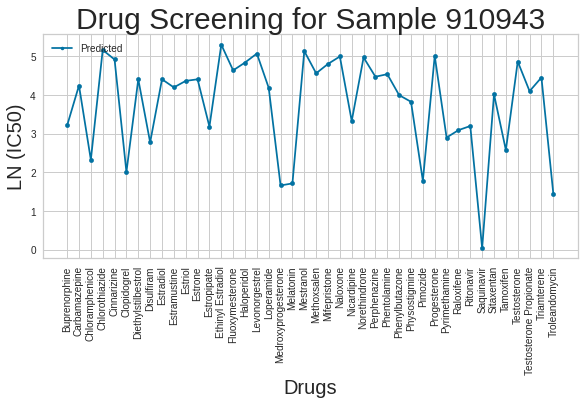

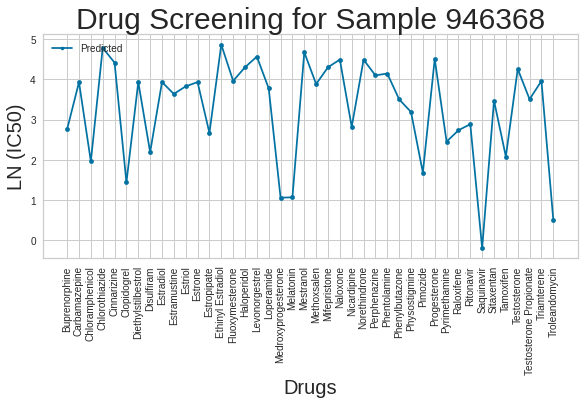

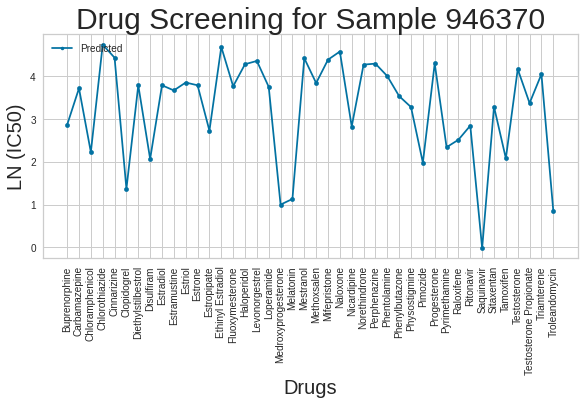

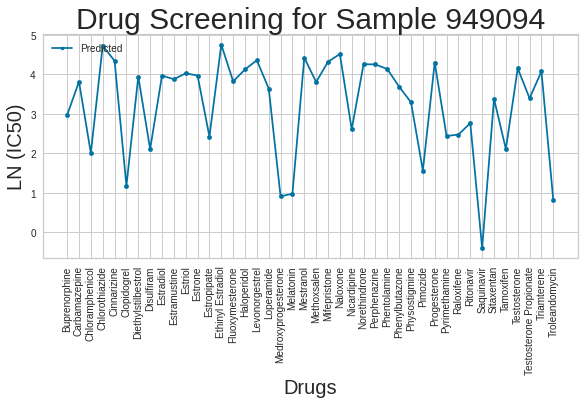

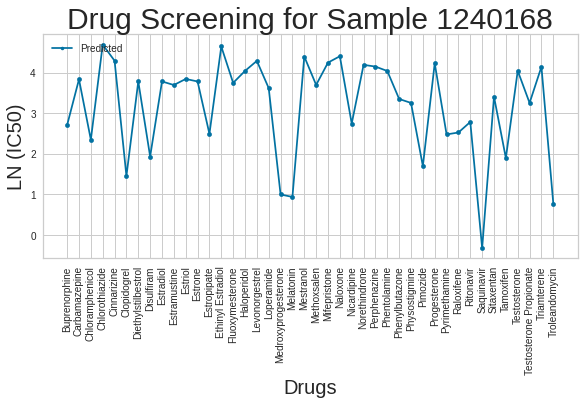

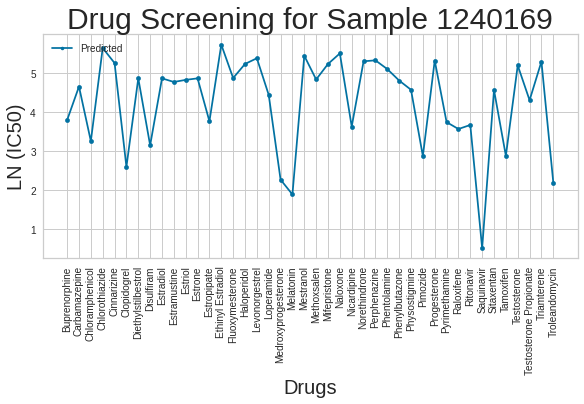

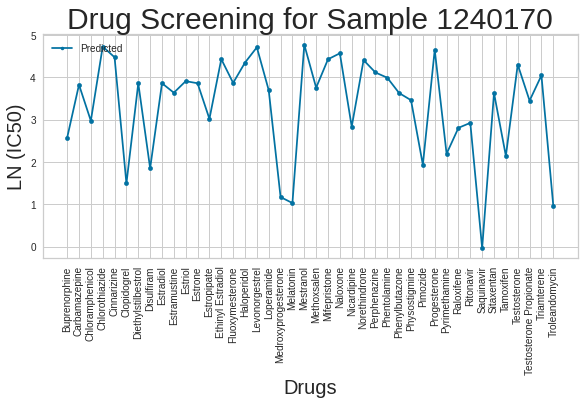

In [125]:
for samp in samples:
    fig, ax = plt.subplots(constrained_layout=True)
    t_predx1 =unseen_predict1.copy(deep=True)
    t_predx1 = t_predx1[t_predx1['SAMPLE_ID']==samp]
    t_predx1.sort_values(by=['DRUG_CODE'],inplace=True)
    t_predx1.reset_index(inplace=True)
    t_predx1.reset_index(inplace=True)
    t_predx1['SAMPLE_ID'] = t_predx1['SAMPLE_ID'].astype('string')

    t_predx1.rename(columns={'Label':'Predicted'},inplace=True)
    #t_predx1.plot.line(ax=ax,y='Real', rot=90, marker='.',title=f'Drug Screening for KIRC')
    t_predx1.plot.line(y='Predicted', ax=ax,rot=90 , marker='.',title=f'Drug Screening for Sample {samp}')
    t_predx1.plot(y='Predicted',x='DRUG_NAME',kind='scatter',ax=ax,rot=90)
    #ax.set_xticks(t_predx1.index)
    #ax.set_xticklabels(t_predx1['SAMPLE_ID'],Fontsize=5)
    #ax.set_yticklabels(Fontsize=20)
    ax.set_xlabel("Drugs", fontdict={'fontsize':20})
    ax.set_ylabel("LN (IC50)",fontdict={'fontsize':20})
    ax.legend(loc=2,fontsize=10)
    ax.title.set_size(30)
    #secax = ax.secondary_xaxis('top')
    #secax.set_xticks(t_predx1.DRUG_CODE)
    #secax.set_xticklabels(t_predx1.DRUG_CODE,Fontsize=5,rotation = 90)

    ax.figure.savefig(f'../../D2GNets/plot/repurpose/{samp}_repurposing.pdf')